In [1]:
#get data

from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide()
fs_peptide.cache()

In [2]:
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [3]:
data_dir = 'C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\\trajectories'

In [4]:
from msmbuilder.dataset import dataset
xyz = dataset(data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=1)

print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

C:\Users\Christian\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


1 trajectories
with length set([14000.0]) ns


In [5]:
#featurization

from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(28000L, 264L, 3L)
(28000L, 84L)


In [6]:
#tICA

from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = diheds.fit_with(tica_model)
tica_trajs = diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(28000L, 84L)
(28000L, 4L)


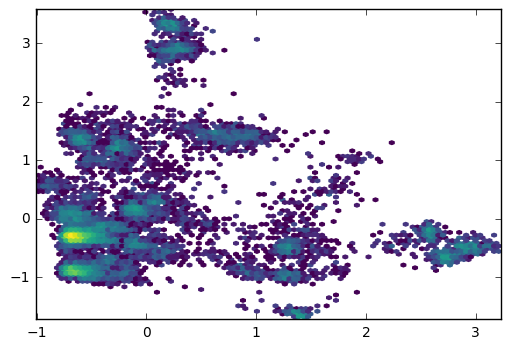

In [7]:
#histogram

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')

In [8]:
#clustering
from msmbuilder.cluster import MiniBatchKMeans
num_cluster = 97
clusterer = MiniBatchKMeans(n_clusters=num_cluster, max_no_improvement=1000)
#clusterer = MiniBatchKMeans(n_clusters=97, n_init=25, max_no_improvement=None)
clustered_trajs = tica_trajs.fit_transform_with(clusterer, 'kmeans/', fmt='dir-npy')

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(28000L, 4L)
(28000L,)


In [9]:
len(clusterer.cluster_centers_[:,0])

97

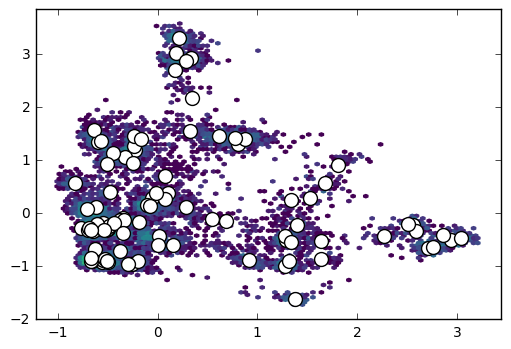

In [10]:
#show cluster

plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [11]:
#msm builder

from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20,  ergodic_cutoff='off')
msm.fit(clustered_trajs)

C:\Users\Christian\Anaconda2\lib\site-packages\msmbuilder\msm\msm.py:183: UserWarning: reversible_type='mle' and ergodic_cutoff <= 0 are not generally compatible
  warnings.warn("reversible_type='mle' and ergodic_cutoff <= 0 "


MarkovStateModel(ergodic_cutoff='off', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

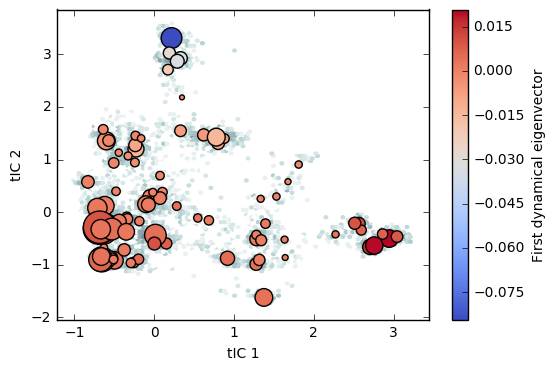

In [12]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
#plt.tight_layout()

In [13]:
from msmbuilder.tpt import mfpts 
mfpt_matrix = mfpts(msm)
print len(mfpt_matrix)


97


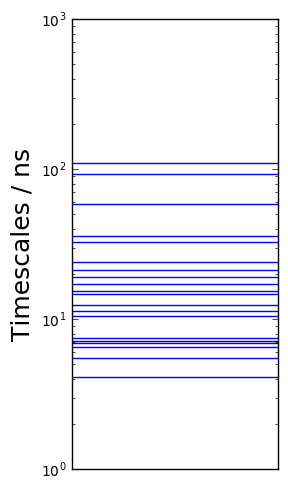

In [14]:

plt.subplots(figsize=(3,5))
plt.hlines(msm.timescales_ * to_ns, 0, 1, color='b')
plt.yscale('log')
plt.xticks([])
plt.ylabel("Timescales / ns", fontsize=18)
plt.tight_layout()

In [15]:
#macrostate model

from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.934496
         Iterations: 12
         Function evaluations: 131


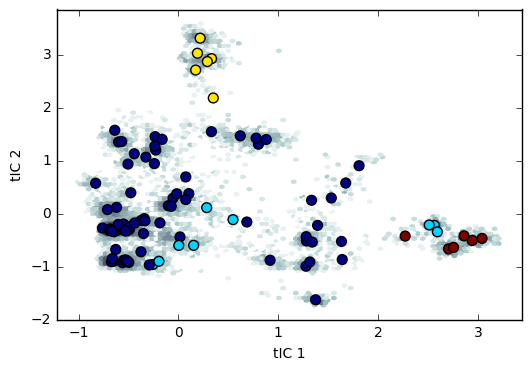

In [16]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
)
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')

In [17]:
# Sample along the 1st tICA coordinate

import mdtraj as md
first_tICA = txx[:,0]
idx_sort = first_tICA.argsort()[-len(first_tICA):][::-1]
sample_rate = int(len(X)/3000) # sample only 3000 frames equally spaced apart
traj = idx_sort[::sample_rate]
tICA_traj = np.reshape(X[traj,:], (len(traj), len(X[0])/3, 3))

md_traj = md.Trajectory(tICA_traj, md.load(fs_peptide.data_dir + '/fs-peptide.pdb').topology)

md_traj.save_xtc('tICA_traj.xtc')


NameError: name 'X' is not defined

In [18]:
lv = msm.left_eigenvectors_
idx_sort = msm.populations_.argsort()[-len(msm.populations_):][::-1]
lv = lv[idx_sort,:]

lv_og = np.load('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\Eigen_Data\\lv_fs_original_stride_10.dat')
print np.dot(lv_og[:,0], lv[:,0])/(np.linalg.norm(lv_og[:,0])*np.linalg.norm(lv[:,0]))
print msm.populations_[idx_sort]

0.944755873354
[ 0.05432533  0.05034379  0.04858451  0.04196054  0.03225249  0.02911497
  0.02441963  0.02416622  0.02226235  0.02072047  0.0195567   0.01939012
  0.01828289  0.01807535  0.01640623  0.01634546  0.0162348   0.0161772
  0.01594699  0.01590457  0.01564586  0.01452933  0.01428243  0.01319734
  0.01200247  0.01181449  0.01115556  0.01051332  0.01046022  0.01004146
  0.00988431  0.00987788  0.00984665  0.00940392  0.00920438  0.00873871
  0.00861187  0.00819556  0.00818595  0.00811766  0.00806632  0.00796823
  0.00783033  0.0076193   0.00759075  0.00752783  0.0071619   0.00696388
  0.00695477  0.00664645  0.00651141  0.00637689  0.0061849   0.00613762
  0.00598069  0.00577969  0.0056896   0.00564431  0.00563822  0.00553745
  0.00526367  0.00510439  0.0050249   0.00483855  0.00482604  0.0047864
  0.00469932  0.00466422  0.00458889  0.00456579  0.00442313  0.0042908
  0.00423947  0.00420184  0.00391954  0.00389769  0.00388594  0.00370811
  0.0036966   0.00364214  0.0035697   0